# CSE 572: Lab 3

In this lab, you will practice implementing some of the data preparation techniques we learned in class including sampling, splitting, discretization, and scaling transforms.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button.

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit 1) a link to your Colab notebook, 2) the .ipynb file, and **3) a pdf of the executed notebook** on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.


## Data preparation

Data mining helps us find patterns in data that we can use to make predictions about new data points, e.g., to predict a target class or other value from a set of features. To help the data mining algorithm find the patterns we are looking for and make correct predictions, we need to construct the data set and transform the data correctly.

First, load the Wisconsin Breast Cancer dataset and apply the operations to remove nans, duplicates, and outliers from Lab 2.

In [ ]:
# Load the original dataset
import pandas as pd
import numpy as np

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']

data = data.drop(['Sample code'],axis=1)

data = data.replace('?',np.NaN)
data['Bare Nuclei'] = pd.to_numeric(data['Bare Nuclei'])

data

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,1,2
695,2,1,1,1,2,1.0,1,1,1,2
696,5,10,10,3,7,3.0,8,10,2,4
697,4,8,6,4,3,4.0,10,6,1,4


In [ ]:
def inds_nans(df):
    inds = df.isna().any(axis=1)
    # print('Found {} rows that had NaN values.'.format(inds.sum()))
    return inds

def inds_dups(df):
    inds = df.duplicated()
    # print('Found {} rows that were duplicates.'.format(inds.sum()))
    return inds

def inds_outliers(df):
    # In this example, we defined outliers as values that are +/- 3 standard deviations
    # from the mean value. To identify such values, we need to compute the Z score for
    # every value by subtracting the feature-wise mean and dividing by the feature-wise
    # standard deviation (also known as standardizing the data).
    df = df[df.columns[:-1]]
    Z = (df-df.mean())/df.std()
    # The below code will give a value of True or False for each row. The row will be
    # True if all of the feature values for that row were within 3 standard deviations of
    # the mean. The row will be False if at leaset one of the feature values for that row
    # was NOT within 3 standard deviations of the mean.
    inlier_inds = ((Z > -3).sum(axis=1)==9) & ((Z <= 3).sum(axis=1)==9)
    # The outliers are the inverse boolean values of the above
    outlier_inds = ~inlier_inds
    # print('Found {} rows that were outliers.'.format(outlier_inds.sum()))
    return outlier_inds

In [ ]:
# Select only the rows at index locations that were not nans, duplicates, or outliers
data_clean = data.loc[~((inds_nans(data) | inds_dups(data)) | inds_outliers(data)),:]

data_clean

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
693,3,1,1,1,2,1.0,2,1,2,2
694,3,1,1,1,3,2.0,1,1,1,2
696,5,10,10,3,7,3.0,8,10,2,4
697,4,8,6,4,3,4.0,10,6,1,4


### Sampling

Sampling is an approach commonly used to facilitate (1) data reduction for exploratory data analysis and scaling up algorithms to big data applications and (2) quantifying uncertainties due to varying data distributions. There are various methods available for data sampling, such as simple random vs. stratified random sampling, or sampling without replacement (where each selected instance is removed from the dataset) vs. sampling with replacement (where each selected instance is not removed, thus allowing it to be selected more than once in the sample).

In the example below, we will apply sampling with replacement and without replacement to the breast cancer dataset.

In the following code, a sample of size 3 is randomly selected (without replacement) from the original data.

In [ ]:
sample = data_clean.sample(n=3)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
480,5,1,1,1,1,1.0,1,1,1,2
694,3,1,1,1,3,2.0,1,1,1,2
13,1,1,1,1,2,3.0,3,1,1,2


In the next example, we randomly select 1% of the data (without replacement) and display the selected samples. The random_state argument of the function specifies the seed value of the random number generator.

In [ ]:
sample = data_clean.sample(frac=0.01, random_state=1)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
266,10,10,6,3,3,10.0,4,3,2,4
610,10,4,3,10,3,10.0,7,1,2,4
404,1,2,1,3,2,1.0,1,2,1,2
442,1,1,1,3,2,3.0,1,1,1,2


Alternatively, we could perform a sampling with replacement to create a sample whose size is equal to 1% of the entire data. You should be able to observe duplicate instances in the sample by increasing the sample size. You can identify duplicate instances in this sample by their row index (bold far-left column).

In [ ]:
sample = data_clean.sample(frac=0.01, replace=True, random_state=1)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
41,10,4,3,1,3,3.0,6,5,2,4
382,3,2,2,2,2,1.0,3,2,1,2
696,5,10,10,3,7,3.0,8,10,2,4
87,3,6,6,6,5,10.0,6,8,3,4


Text(0, 0.5, 'Number of duplicate rows in sample')

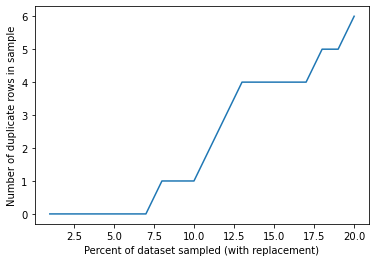

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1)

dups = []
# Sample fractions from 0.01 to 0.20 and observe how the number of duplicates increases
for frac in range(1, 21, 1):
    sample = data_clean.sample(frac=frac/100., replace=True, random_state=1)
    num_dups = inds_dups(sample)[inds_dups(sample)==True].shape[0]
    dups.append(num_dups)

ax.plot(range(1, 21, 1), dups)
ax.set_xlabel('Percent of dataset sampled (with replacement)')
ax.set_ylabel('Number of duplicate rows in sample')

The previous examples use a simple random sampling strategy in which each sample has equal probability of inclusion in the sample. Another sampling strategy is *stratified* random sampling, in which we split the data into several partitions (i.e., groups) then randomly sample from each partition. The next example demonstrates a stratified random sample that uses the Class values as groups to sample from.

In [ ]:
data_clean.groupby('Class', group_keys=False).apply(lambda grp: grp.sample(n=5, random_state=1))

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
108,1,1,1,1,2,1.0,2,3,1,2
622,7,1,2,3,2,1.0,2,1,1,2
120,1,1,2,2,2,1.0,3,1,1,2
673,5,3,2,1,3,1.0,1,1,1,2
79,2,1,1,1,3,1.0,2,1,1,2
86,3,3,6,4,5,8.0,4,4,1,4
211,8,10,8,8,4,8.0,7,7,1,4
330,10,4,7,2,2,8.0,6,1,1,4
353,2,7,10,10,7,10.0,4,9,4,4
246,8,10,10,8,5,10.0,7,8,1,4


Instead of specifying the number of samples from each group, use the `frac` argument to sample 5% of the instances from each class. Set the `random_state = 1` for reproducibility and make sure to sample from `data_clean`.

In [ ]:
# YOUR CODE HERE
data_clean.groupby('Class', group_keys=False).apply(lambda grp: grp.sample(frac=0.05, random_state=1)).value_counts('Class')

Class
2    10
4     9
dtype: int64

**Question 1: How many instances of the benign vs. malevolent class does this sample result in?**

**Answer:**
10 benign, 9 malevolent

### Discretization

Discretization is a data preprocessing step that is often used to transform a continuous-valued attribute to a categorical attribute. The example below illustrates two simple but widely-used unsupervised discretization methods (equal width and equal depth) applied to the 'Clump Thickness' attribute of the breast cancer dataset.

First, we plot a histogram that shows the distribution of the attribute values. The value_counts() function can also be applied to count the frequency of each attribute value.

1     48
2     24
3     54
4     45
5     87
6     25
7     19
8     36
9      9
10    52
Name: Clump Thickness, dtype: int64

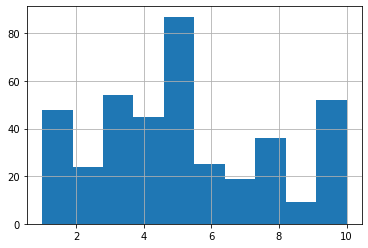

In [ ]:
data_clean['Clump Thickness'].hist(bins=10)
data_clean['Clump Thickness'].value_counts(sort=False)

For the equal width method, we can apply the cut() function to discretize the attribute into 4 bins of similar interval widths. The value_counts() function can be used to determine the number of instances in each bin.

In [ ]:
bins = pd.cut(data_clean['Clump Thickness'], 4)
bins.value_counts(sort=False)

(0.991, 3.25]    126
(3.25, 5.5]      132
(5.5, 7.75]       44
(7.75, 10.0]      97
Name: Clump Thickness, dtype: int64

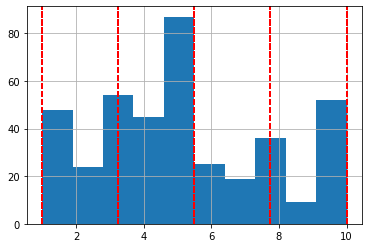

In [ ]:
# Plot the boundaries of the bin intervals resulting from the cut
fig, ax = plt.subplots(1)
data_clean['Clump Thickness'].hist(bins=10, ax=ax)

for b in bins:
    ax.axvline(x=b.left, color='red', linestyle='--')
    ax.axvline(x=b.right, color='red', linestyle='--')

For the equal frequency method, the qcut() function can be used to partition the values into 4 bins such that each bin has a similar number of instances.

In [ ]:
bins = pd.qcut(data_clean['Clump Thickness'], 4)
bins.value_counts(sort=False)

(0.999, 3.0]    126
(3.0, 5.0]      132
(5.0, 7.0]       44
(7.0, 10.0]      97
Name: Clump Thickness, dtype: int64

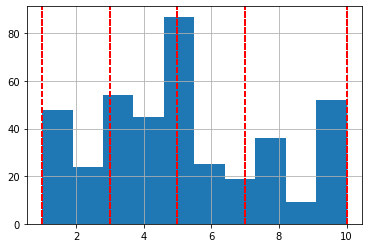

In [ ]:
# Plot the boundaries of the bin intervals resulting from the cut
fig, ax = plt.subplots(1)
data_clean['Clump Thickness'].hist(bins=10, ax=ax)

for b in bins:
    ax.axvline(x=b.left, color='red', linestyle='--')
    ax.axvline(x=b.right, color='red', linestyle='--')

Use the qcut() function to partition the Clump Thickness data into 3 intervals with approximately equal frequency.

In [ ]:
# YOUR CODE HERE
bins = pd.qcut(data_clean['Clump Thickness'], 3)

Get the value counts in each bin.

In [ ]:
# YOUR CODE HERE
bins.value_counts(sort=False)

(0.999, 4.0]    171
(4.0, 6.0]      112
(6.0, 10.0]     116
Name: Clump Thickness, dtype: int64

Plot the histogram and bin intervals for the Clump Thickness data partitioned into 3 equal frequency intervals.

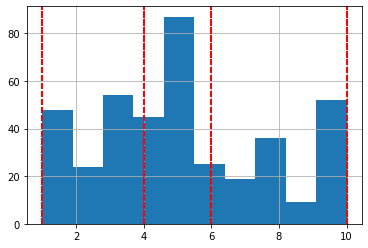

In [ ]:
# YOUR CODE HERE
# Plot the boundaries of the bin intervals resulting from the cut
fig, ax = plt.subplots(1)
data_clean['Clump Thickness'].hist(bins=10, ax=ax)

for b in bins:
    ax.axvline(x=b.left, color='red', linestyle='--')
    ax.axvline(x=b.right, color='red', linestyle='--')

**Question 2: We'll refer to these three bins as small, medium, and large categories of Clump Thickneses. How many samples are in the small, medium, and large bins?**

**Answer:**

YOUR ANSWER HERE

small: 171, medium: 112, large: 116

Alternative accepted answer:

small: 112, medium: 116, large: 171

### Dataset splits

It is common practice in data mining and machine learning to split a dataset into training, validation, and test sets.

- Training set: subset of dataset used for training/fitting model parameters
- Validation set: subset of dataset used to evaluate model generalization performance and tune hyperparameters (model choices)
- Test set: subset of dataset used to test performance after initial vetting using validation set

The training set is usually allocated the largest percentage of the total dataset. For example, a common split might be 60/20/20\% or 80/10/10\% of the data assigned to training/validation/test subsets respectively.

This example shows how to split the dataset into training, validation, and test subsets using a simple random sampling strategy (without replacement).

In [ ]:
# Sample 60% of the instances for the training set
train = data_clean.sample(frac=0.6, random_state=1)
train

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
266,10,10,6,3,3,10.0,4,3,2,4
610,10,4,3,10,3,10.0,7,1,2,4
404,1,2,1,3,2,1.0,1,2,1,2
442,1,1,1,3,2,3.0,1,1,1,2
456,10,6,5,8,5,10.0,8,6,1,4
...,...,...,...,...,...,...,...,...,...,...
54,10,5,5,6,8,8.0,7,1,1,4
154,1,1,1,1,2,1.0,1,1,1,2
273,7,2,4,1,3,4.0,3,3,1,4
352,3,4,5,3,7,3.0,4,6,1,2


In [ ]:
# Sample 20% for the validation set.
# First we need to drop the training instances from our dataframe to sample from the remaining instances.
data_remaining = data_clean.drop(train.index)
# Note that since we are sampling from the rows remaining after removing the training subset, which
# leaves 40% of the total data, we need to sample 50% of the remaining dataset to result in 20% of
# the original dataset.
val = data_remaining.sample(frac=0.5, random_state=1)
val

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
87,3,6,6,6,5,10.0,6,8,3,4
138,4,1,2,1,2,1.0,2,1,1,2
41,10,4,3,1,3,3.0,6,5,2,4
347,1,1,1,1,1,1.0,1,3,1,2
316,5,5,5,2,5,10.0,4,3,1,4
...,...,...,...,...,...,...,...,...,...,...
234,3,3,2,1,3,1.0,3,6,1,2
209,5,1,1,1,1,1.0,3,1,1,2
325,3,2,2,1,2,1.0,2,3,1,2
333,5,4,6,6,4,10.0,4,3,1,4


In [ ]:
# Drop the validation instances from data_remaining
# This leaves us with the remaining 20% of the original dataset,
# which makes up our test set.
test = data_remaining.drop(val.index)
test

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
2,3,1,1,1,2,2.0,3,1,1,2
7,2,1,2,1,2,1.0,3,1,1,2
21,10,5,5,3,6,7.0,7,10,1,4
22,3,1,1,1,2,1.0,2,1,1,2
25,5,2,3,4,2,7.0,3,6,1,4
...,...,...,...,...,...,...,...,...,...,...
625,3,1,3,1,3,4.0,1,1,1,2
635,3,1,4,1,2,1.0,1,1,1,2
671,3,2,1,2,2,1.0,3,1,1,2
687,3,1,1,1,2,1.0,2,3,1,2


Use `value_counts()` to get the number of benign vs. malevolent examples in each subset.

In [ ]:
# YOUR CODE HERE
print(train.value_counts('Class'))
print(val.value_counts('Class'))
print(test.value_counts('Class'))

Class
2    130
4    109
dtype: int64
Class
4    45
2    35
dtype: int64
Class
2    45
4    35
dtype: int64


**Question 3: How many benign and malevolent samples are in the training, validation, and test subset?**

**Answer:**

YOUR ANSWER HERE

train: 130 benign, 109 malevolent; val: 35 benign, 45 malevolent; test: 45 benign, 35 malevolent

**Question 4: In this example, we sampled the dataset splits without replacement. Why is it important to use a sampling strategy *without* replacement, as opposed to using a sampling strategy *with* replacement?**

**Answer:**

YOUR ANSWER HERE

Sampling with replacement would result in the same instances being included in the training, validation, and test sets, which would result in autocorrelation between the datasets and overestimate the performance of a model on the validation or test set since the subsets were not independent.

## Feature scaling

Many algorithms perform better when the values of all features have a similar range of values or are distributed a certain way (e.g., Gaussian-distributed). In lecture, we discussed several ways of transforming data. We will implement some of these scaling transformations here.

First, plot a histogram of the raw values for each feature.

In [ ]:
# First let's drop the Class column since we only want to
# apply transformations to the features, not the class values
df = data_clean.drop(columns=['Class'])

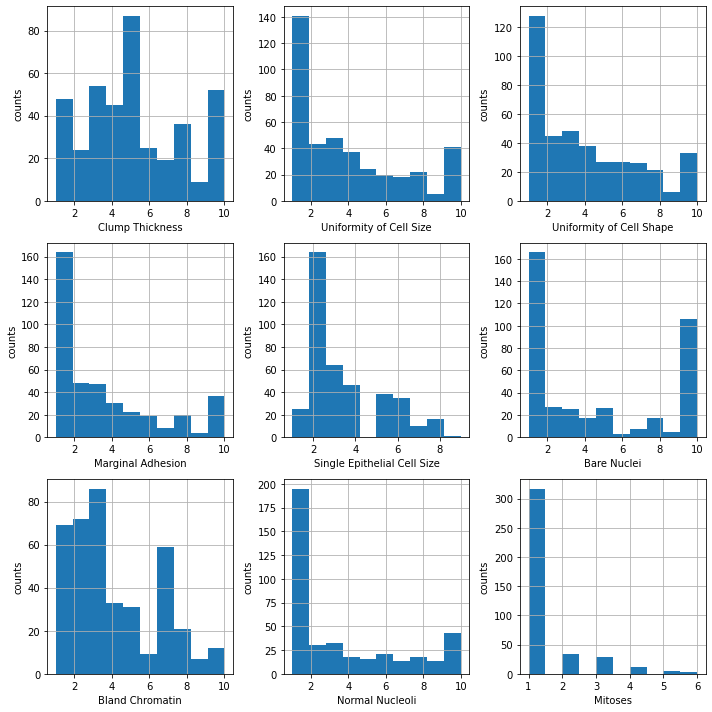

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, col in enumerate(df):
    df[col].hist(bins=10, ax=axes.flat[i])
    axes.flat[i].set_xlabel(col)
    axes.flat[i].set_ylabel('counts')

fig.tight_layout()

### Standardization

We already applied one type of scaling transformation when we computed the Z scores to identify outliers earlier in Lab 3 and in Lab 2. Standardization (also called Z-score scaling) scales all features to have 0 mean and unit variance. For each sample, we subtract the mean and divide by the standard deviation; the mean and standard deviation are computed for each feature.

We can compute the mean and standard deviation for each feature as follows:

In [ ]:
df.mean()

Clump Thickness                5.125313
Uniformity of Cell Size        3.799499
Uniformity of Cell Shape       3.872180
Marginal Adhesion              3.426065
Single Epithelial Cell Size    3.348371
Bare Nuclei                    4.513784
Bland Chromatin                3.949875
Normal Nucleoli                3.536341
Mitoses                        1.403509
dtype: float64

In [ ]:
df.std()

Clump Thickness                2.794347
Uniformity of Cell Size        3.045699
Uniformity of Cell Shape       2.929868
Marginal Adhesion              2.967821
Single Epithelial Cell Size    1.824303
Bare Nuclei                    3.829164
Bland Chromatin                2.523755
Normal Nucleoli                3.248201
Mitoses                        0.929736
dtype: float64

The following example applies the Z-score scaling to the dataset.

In [ ]:
Z = (df - df.mean()) / df.std()
Z

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,-0.044845,-0.919165,-0.980311,-0.817457,-0.739116,-0.917637,-0.376374,-0.780845,-0.434003
1,-0.044845,0.065831,0.043626,0.530333,2.001657,1.432745,-0.376374,-0.472982,-0.434003
2,-0.760576,-0.919165,-0.980311,-0.817457,-0.739116,-0.656484,-0.376374,-0.780845,-0.434003
3,0.313020,1.379158,1.408876,-0.817457,-0.190961,-0.134177,-0.376374,1.066331,-0.434003
4,-0.402711,-0.919165,-0.980311,-0.143562,-0.739116,-0.917637,-0.376374,-0.780845,-0.434003
...,...,...,...,...,...,...,...,...,...
693,-0.760576,-0.919165,-0.980311,-0.817457,-0.739116,-0.917637,-0.772608,-0.780845,0.641570
694,-0.760576,-0.919165,-0.980311,-0.817457,-0.190961,-0.656484,-1.168843,-0.780845,-0.434003
696,-0.044845,2.035822,2.091501,-0.143562,2.001657,-0.395330,1.604801,1.989920,0.641570
697,-0.402711,1.379158,0.726251,0.193386,-0.190961,-0.134177,2.397271,0.758469,-0.434003


Now, plot the histograms for the standardized features. Notice that the distributions look visually the same, but the ranges of the values on the x axes have been squashed into a smaller range. For example, Clump Thickness previously ranged from 1 to 10, but now ranges from approximately -1.5 to 1.5.

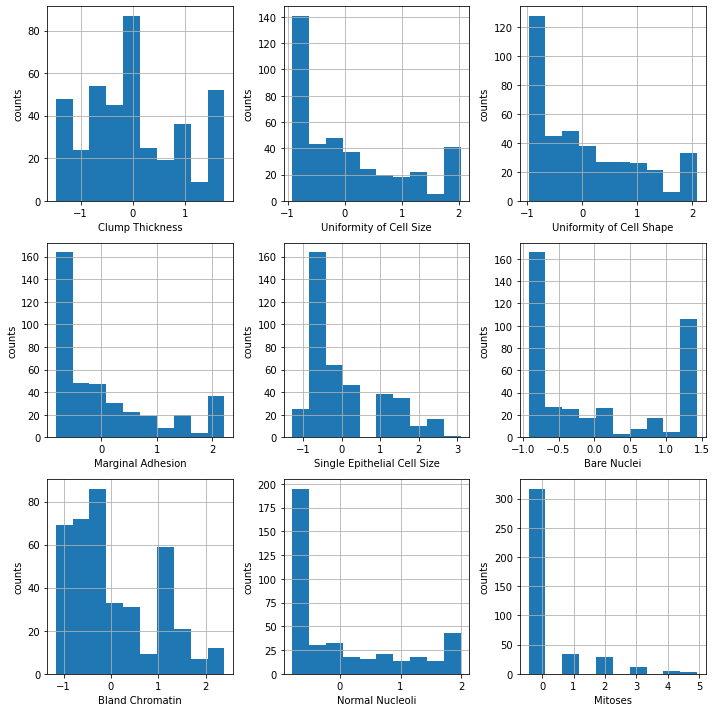

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, col in enumerate(df):
    Z[col].hist(bins=10, ax=axes.flat[i])
    axes.flat[i].set_xlabel(col)
    axes.flat[i].set_ylabel('counts')

fig.tight_layout()

### Normalization

Normalization scales all samples to have unit norm (vector length). The below example demonstrates normalizing the data using the L2 norm (Euclidean distance). Note that we use the library sklearn to do this transformation; sklearn has many preprocessing and scaling utilities that you can read more about here: https://scikit-learn.org/stable/modules/preprocessing.html

In [ ]:
from sklearn import preprocessing
import numpy as np

df_norm = preprocessing.normalize(df, norm='l2')

# We can check that the features indeed have unit norm now by printing the L2 norm of one sample
print(np.linalg.norm(df_norm[0], ord=2))

1.0


Observe the effect of this normalization on the feature distributions. After *normal*ization, they now appear approximately *normally* distributed.

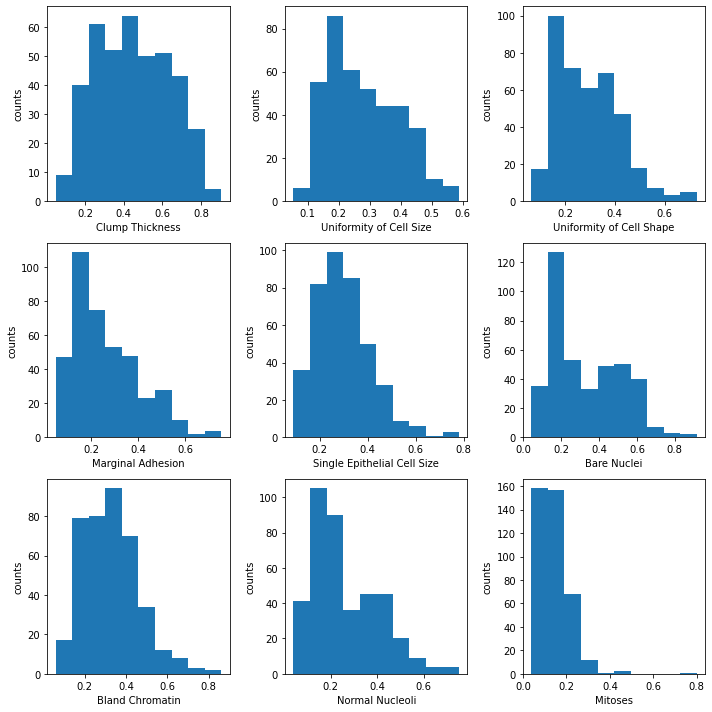

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, col in enumerate(df):
    axes.flat[i].hist(df_norm[:,i], bins=10)
    axes.flat[i].set_xlabel(col)
    axes.flat[i].set_ylabel('counts')

fig.tight_layout()

Instead of using the L2 norm to normalize the dataset, try using the L1 norm. You can do this simply by passing `norm=l1` instead of `l2` as we did above.

In [ ]:
# YOUR CODE HERE
df_norm_l1 = preprocessing.normalize(df, norm='l1')

Check that the norm of each sample is 1 by printing the l1 norm of the first sample (same as we did in the above example).

In [ ]:
# YOUR CODE HERE
print(np.linalg.norm(df_norm_l1[0], ord=1))

1.0


### Linear scaling

The equation for linear scaling shown in lecture was the following:

$x_i = (x_i - min_i ) / (max_i - min_i)$

The code below demonstrates how to compute this transformation.

In [ ]:
linscale = (df - df.min()) / (df.max() - df.min())

Using the `describe()` function to describe the scaled dataset statistics, we see that the min and max range for each feature is now [0, 1].

In [ ]:
linscale.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,0.458368,0.311055,0.319131,0.269563,0.293546,0.390420,0.327764,0.281816,0.080702
std,0.310483,0.338411,0.325541,0.329758,0.228038,0.425463,0.280417,0.360911,0.185947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.000000,0.000000,0.000000,0.125000,0.000000,0.111111,0.000000,0.000000
50%,0.444444,0.222222,0.222222,0.111111,0.250000,0.222222,0.222222,0.111111,0.000000
75%,0.666667,0.555556,0.555556,0.444444,0.437500,1.000000,0.555556,0.555556,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### MinMax scaling

MinMax scaling is similar to the above but allows us to specify the min and max that we want our data to have. This is described by the following equations:

$std_i = (x_i - min_i ) / (max_i - min_i)$
$x_i = std_i * (max - min) + min$

where $max$ and $min$ are the desired max and min values.

For example, if we want the features to range from [-1, 1], we would apply the following transformation:

$x_i = std_i * (1 - (-1)) + (-1)$

This is demonstrated in the code example below.

In [ ]:
minmax = linscale * (1 - (-1)) + (-1)

Using the `describe()` function to describe the scaled dataset statistics, we see that the min and max range for each feature is now [-1, 1].

In [ ]:
minmax.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,-0.083264,-0.377889,-0.361738,-0.460874,-0.412907,-0.219159,-0.344472,-0.436369,-0.838596
std,0.620966,0.676822,0.651082,0.659516,0.456076,0.850925,0.560834,0.721823,0.371895
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.555556,-1.000000,-1.000000,-1.000000,-0.750000,-1.000000,-0.777778,-1.000000,-1.000000
50%,-0.111111,-0.555556,-0.555556,-0.777778,-0.500000,-0.555556,-0.555556,-0.777778,-1.000000
75%,0.333333,0.111111,0.111111,-0.111111,-0.125000,1.000000,0.111111,0.111111,-1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
